In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
#pip install xgboost


In [3]:
df = pd.read_csv('incoming_daily_till2023may_interpolated.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    881 non-null    object 
 1   volume  881 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.9+ KB


In [5]:
# Assuming 'timestamp' is the column containing the irregular timestamps and 'value' is the column containing the volume data
df['date'] = pd.to_datetime(df['date'],format="%Y/%m/%d")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    881 non-null    datetime64[ns]
 1   volume  881 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 13.9 KB


In [7]:
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 881 entries, 2021-01-01 to 2023-05-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   volume  881 non-null    float64
dtypes: float64(1)
memory usage: 13.8 KB


In [11]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=7, shuffle=False)
train.columns = df.columns
test.columns = df.columns
print(f"{train.shape[0]} train and {test.shape[0]} test instances")

704 train and 177 test instances


In [14]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [22]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofweek']
TARGET = 'volume'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [23]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,   #stop the model training early if the test set is not improving after 50 trees
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01) #so that it doesn't overfit the model
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100) #give output of trees based on interval of 100

[22:47:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:691.72666	validation_1-rmse:1132.79938
[100]	validation_0-rmse:365.25602	validation_1-rmse:767.28980
[200]	validation_0-rmse:294.52299	validation_1-rmse:644.00382
[300]	validation_0-rmse:283.56201	validation_1-rmse:601.52545
[400]	validation_0-rmse:282.03966	validation_1-rmse:586.38132
[500]	validation_0-rmse:281.83202	validation_1-rmse:580.88846
[600]	validation_0-rmse:281.80373	validation_1-rmse:578.87454
[700]	validation_0-rmse:281.79987	validation_1-rmse:578.13339
[800]	validation_0-rmse:281.79935	validation_1-rmse:577.86031
[900]	validation_0-rmse:281.79928	validation_1-rmse:577.75960
[999]	validation_0-rmse:281.79927	validation_1-rmse:577.72268


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [24]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,   #stop the model training early if the test set is not improving after 50 trees
                       objective='reg:linear',
                       max_depth=3,
                    ) #so that it doesn't overfit the model
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        ) #give output of trees based on interval of 100

[22:47:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:528.79737	validation_1-rmse:960.68938
[1]	validation_0-rmse:421.79848	validation_1-rmse:839.30088
[2]	validation_0-rmse:357.64067	validation_1-rmse:756.66902
[3]	validation_0-rmse:321.39991	validation_1-rmse:700.50958
[4]	validation_0-rmse:301.96194	validation_1-rmse:662.50221
[5]	validation_0-rmse:291.91400	validation_1-rmse:636.42539
[6]	validation_0-rmse:286.83089	validation_1-rmse:618.46068
[7]	validation_0-rmse:284.28980	validation_1-rmse:606.10527
[8]	validation_0-rmse:283.02979	validation_1-rmse:597.53857
[9]	validation_0-rmse:282.40731	validation_1-rmse:591.55127
[10]	validation_0-rmse:282.09925	validation_1-rmse:587.39076
[11]	validation_0-rmse:281.94729	validation_1-rmse:584.49208
[12]	validation_0-rmse:281.87230	validation_1-r

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

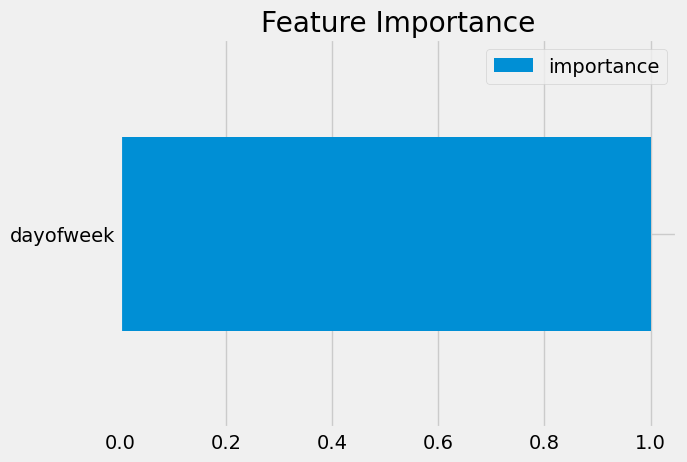

In [25]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

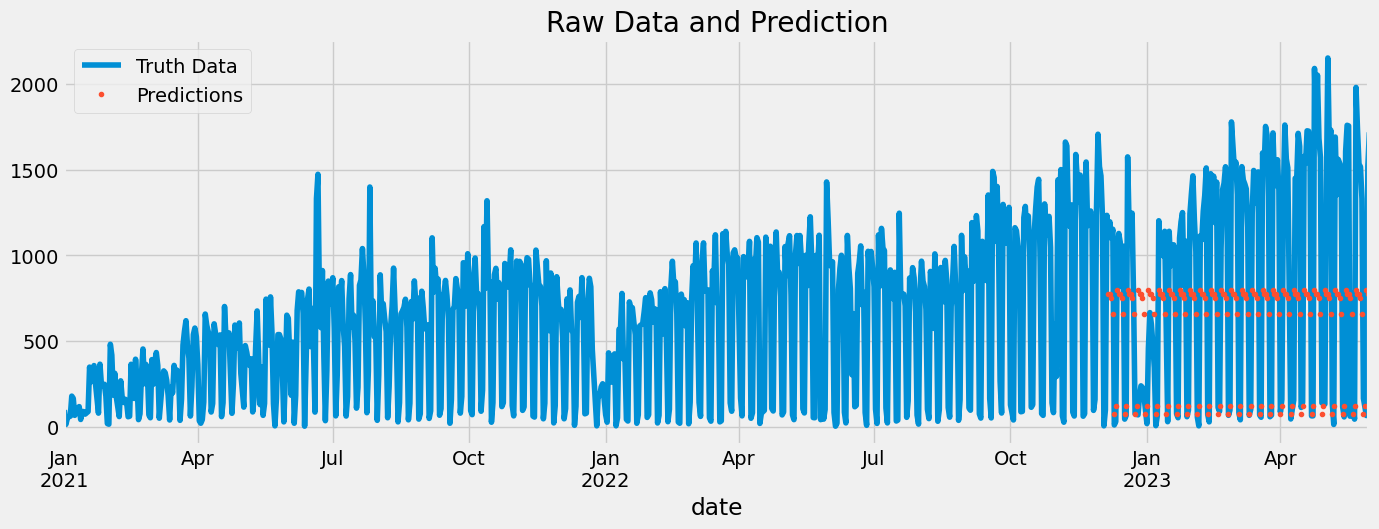

In [26]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['volume']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

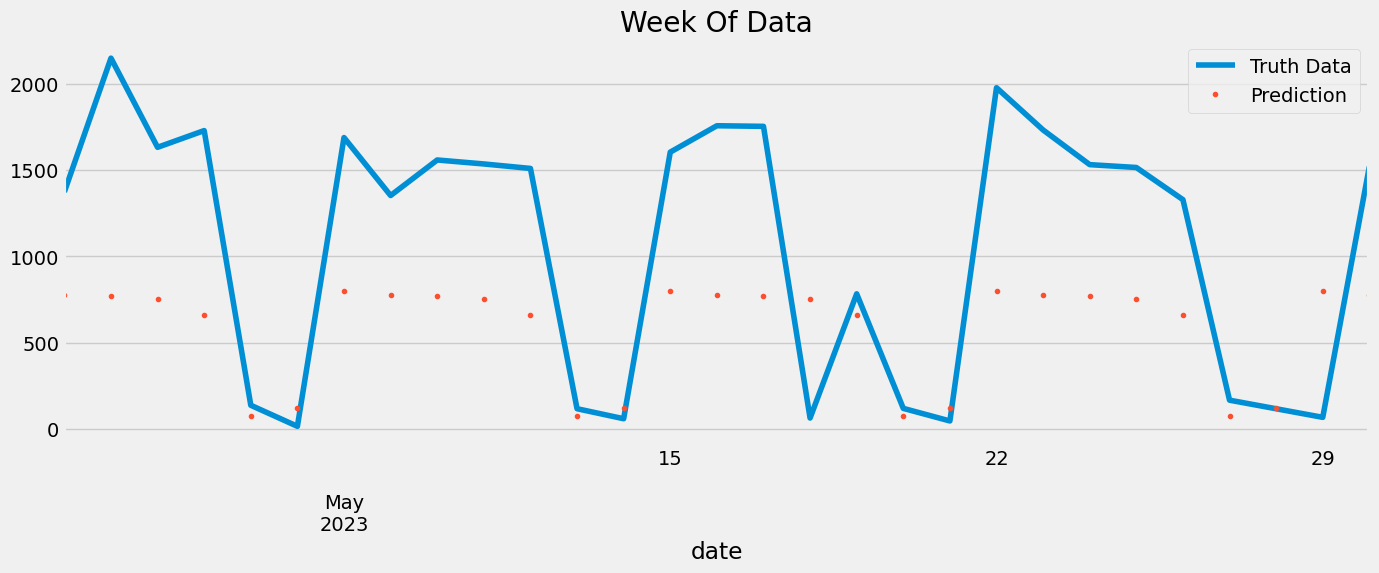

In [27]:
ax = df.loc[(df.index > '05-01-2023') & (df.index < '05-31-2023')]['volume'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '05-01-2023') & (df.index < '05-31-2023')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [28]:
score = np.sqrt(mean_squared_error(test['volume'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 577.70


In [29]:
# 4. Evaluate the Model
predicted = test['prediction']
actual = test['volume']

# Calculate RMSE
rmse = np.sqrt(((predicted - actual) ** 2).mean())
# Calculate MAE
mae = np.abs(predicted - actual).mean()
# Calculate MAPE
mape = (np.abs((actual - predicted) / actual)).mean() * 100
# Calculate Theil's U2
numerator = np.sqrt(np.sum((predicted - actual)**2) / len(actual))
denominator = np.sqrt((np.sum(actual**2) + np.sum(predicted**2)) / (2 * len(actual)))
theils_u2 = numerator / denominator

print(f"RMSE: {rmse}, MAE: {mae}, MAPE: {mape}%, Theil's U2: {theils_u2}")

RMSE: 577.7008540719538, MAE: 460.8152632632498, MAPE: 98.02124192883075%, Theil's U2: 0.625053209844889


In [30]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date_test'] = test.index.date
test.groupby(['date_test'])['error'].mean().sort_values(ascending=False).head(10)   #worst predicted days

date_test
2023-05-03    1377.540161
2023-04-24    1288.204102
2023-04-26    1277.540161
2023-05-22    1177.704102
2023-05-05    1070.174988
2023-05-17     982.040161
2023-04-04     981.924988
2023-05-16     980.424988
2023-03-22     979.040161
2023-02-27     976.704102
Name: error, dtype: float64

In [31]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date_test'] = test.index.date
test.groupby(['date_test'])['error'].mean().sort_values(ascending=True).head(10)   #best predicted days

date_test
2023-02-11     1.118057
2023-01-21     2.381943
2022-12-24     2.881943
2023-03-18     4.118057
2023-05-28     4.433098
2023-02-25     6.118057
2023-03-11     6.118057
2023-03-04     8.881943
2023-04-22     9.118057
2023-04-01    12.381943
Name: error, dtype: float64